# Dremio Test

## Setting up dremio


## Imports

In [1]:
import os
import sys
import atoti as tt

In [2]:
import pandas as pd

Make sure you are running a version of atoti older than 0.8.10. This has been tested on 0.8.5

In [3]:
tt._version.VERSION

'0.8.6'

### Jar Input

In [4]:
dremio_driver_jar="flight-sql-jdbc-driver-10.0.0.jar"
dremio_driver_jar_legacy="dremio-jdbc-driver-24.3.2-202401241821100032-d2d8a497.jar"

### SQL Setup

In [5]:
schema_name='"@admin"'
db_table_name='SampleData20240104'
sql = f"SELECT * FROM {schema_name}.{db_table_name}"

### Database setup

In [6]:
username="admin"
password="admin01!"
host_name="localhost"
port="32010"
database = "Dremio"

jdbc_legacy_url=f"jdbc:dremio:direct={host_name}:31010?user={username}&password={password}&useEncryption=false"
jdbc_url = f"jdbc:arrow-flight-sql://{host_name}:{port}?user={username}&password={password}&useEncryption=false"

jdbc_driver="org.apache.arrow.driver.jdbc.ArrowFlightJdbcDriver"
jdbc_legacy_driver="com.dremio.jdbc.Driver"
atoti_table_name="table_facts"

In [7]:
os.getcwd()

'/Users/gpadya/Documents/dremio-driver/Python Dremio Demo'

## Session

In [8]:
session = tt.Session(
    port=9092,
    user_content_storage = "./Python Dremio Demo/content",
    java_options=["-Dorg.springframework.boot.logging.LoggingSystem=none"],
    extra_jars=[f"./utilities/extra_jars/{dremio_driver_jar}"],
    # app_extensions=tt.ADVANCED_APP_EXTENSION,
    # logging=tt.LoggingConfig(destination=sys.stdout)
    logging=tt.LoggingConfig(destination="./logging/server.log")
)

## Load from Dremio

In [9]:
table_facts_types= {
    "AsofDate" : tt.LOCAL_DATE,
    "CUSIP" : tt.STRING,
    "SectorCode" : tt.STRING,
    "Strategy" : tt.STRING,
    "MarketValue" : tt.DOUBLE,
    "EffectiveDuration" : tt.DOUBLE,
    "OptionAdjustedSpread" : tt.DOUBLE,
    "LegalEntity" : tt.STRING,
    "PortfolioTicker" : tt.STRING,
    "OwnershipType" : tt.STRING,
    "PercentWeight" : tt.INT
}

In [10]:
# table_facts = session.create_table(
#     atoti_table_name,
#     types=table_facts_types,
# )

# table_facts.load_sql(sql,
#                 url=jdbc_url, 
#                 driver=jdbc_driver)

In [11]:
%%time
table_facts=session.read_sql(sql,
                url=jdbc_url, 
                driver=jdbc_driver,
                table_name=atoti_table_name,
)

CPU times: user 21.4 ms, sys: 9.55 ms, total: 30.9 ms
Wall time: 11.7 s


In [12]:
table_facts.head()

,AsofDate,CUSIP,SectorCode,Strategy,MarketValue,EffectiveDuration,OptionAdjustedSpread,LegalEntity,PortfolioTicker,OwnershipType,PercentWeight
0,2024-01-03T22:00:00.000+00:00,91282CFV8,Peaches,Paris,17042127.4,8.809704,3.81681,GEA_BM,NEABMLCWF,Active,1.0
1,2024-01-03T22:00:00.000+00:00,ZRW7M2C57,Apples,Paris,271606.116,0.12641,0.0,GEA_BM,NEABMLCWF,Active,1.0
2,2024-01-03T22:00:00.000+00:00,91282CFT3,Peaches,Paris,12553750.93,6.138696,0.12888,GEA_BM,NEABMLCWF,Passive,1.0
3,2024-01-03T22:00:00.000+00:00,91282CFT3,Peaches,Paris,12553750.93,6.138696,0.12888,GEA_BM,NEABMLCWF,Active,1.0
4,2024-01-03T22:00:00.000+00:00,91282CHU8,Peaches,Paris,3714821.534,2.892528,0.0,GEA_BM,NEABMLCWF,Passive,1.0


## Create Cube

In [13]:
cube = session.create_cube(table_facts, name="facts", mode="no_measures")
h, l, m = cube.hierarchies, cube.levels, cube.measures

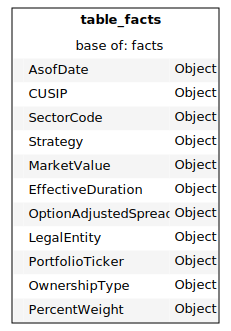

In [14]:
session.tables.schema

### Clean Up Hierarchies

In [15]:
del(h['MarketValue'],h['EffectiveDuration'], h['OptionAdjustedSpread'], h['PercentWeight'])

## Add Measures

In [16]:
%%time
m["MarketValue"] = tt.agg.sum(table_facts["MarketValue"])
m["EffectiveDuration"] = tt.agg.sum(table_facts["EffectiveDuration"])
m["EffectiveDuration"] = tt.agg.sum(table_facts["EffectiveDuration"])
m["OptionAdjustedSpread"] = tt.agg.sum(table_facts["OptionAdjustedSpread"])
m["PercentWeight"] = tt.agg.sum(table_facts["PercentWeight"])

CPU times: user 4.5 ms, sys: 2.37 ms, total: 6.86 ms
Wall time: 212 ms


In [17]:
%%time
m["MV Duration"] = tt.agg.sum_product(
    table_facts["MarketValue"],table_facts["EffectiveDuration"],table_facts["PercentWeight"])

CPU times: user 3.87 ms, sys: 2.99 ms, total: 6.86 ms
Wall time: 44.6 ms


In [18]:
%%time
m["MV PercentWeight"] = tt.agg.sum_product(table_facts["MarketValue"],table_facts["PercentWeight"])

CPU times: user 2.12 ms, sys: 2.44 ms, total: 4.56 ms
Wall time: 30.9 ms


In [19]:
%%time
m["MV OAS"] = tt.agg.sum_product(table_facts["MarketValue"],table_facts["OptionAdjustedSpread"],table_facts["PercentWeight"])

CPU times: user 2.11 ms, sys: 2.64 ms, total: 4.75 ms
Wall time: 30.7 ms


In [20]:
%%time
m["Weighted Average Duration"] = tt.where(m["MV PercentWeight"] == 0, 0, m["MV Duration"]/m["MV PercentWeight"])

CPU times: user 5.29 ms, sys: 2.77 ms, total: 8.07 ms
Wall time: 53.2 ms


In [21]:
%%time
m["Weighted Average Duration OAS"] = tt.where(m["MV PercentWeight"] == 0, 0, m["MV OAS"]/m["MV PercentWeight"])

CPU times: user 2.71 ms, sys: 2.52 ms, total: 5.24 ms
Wall time: 19.8 ms


## Link to UI

In [22]:
session.link

http://localhost:9092

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.